* Testing Double DQN in Simple game
* Using Neural Network as Q
* See https://arxiv.org/abs/1509.06461

In [1]:
import copy
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import chainer
import chainer.links as L
import chainer.functions as F
import gym

In [2]:
env = gym.make("FrozenLake-v0")
print("observation_space.n:", env.observation_space.n)
print("action_space.n: ", env.action_space.n)
print("-"*50)

obs = env.reset()
print("obs: ", obs)
env.render()
print("")

act = env.action_space.sample()
obs = env.step(act)
print("act: ", act)
print("obs: ", obs)
env.render()
print("")

act = env.action_space.sample()
obs = env.step(act)
print("act: ", act)
print("obs: ", obs)
env.render()

observation_space.n: 16
action_space.n:  4
--------------------------------------------------
obs:  0

SFFF
FHFH
FFFH
HFFG

act:  0
obs:  (0, 0.0, False, {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG

act:  3
obs:  (0, 0.0, False, {'prob': 0.3333333333333333})
  (Up)
SFFF
FHFH
FFFH
HFFG


In [3]:
# NNクラス定義

class NN(chainer.Chain):
    
    def __init__(self):
        
        super(NN, self).__init__(
            xc = L.Linear(16, 100),
            ch = L.Linear(100, 100),
            hy = L.Linear(100, 4)
        )
        
    def __call__(self, x):
        
        x = chainer.Variable(x)
        h = F.relu(self.xc(x))
        h = F.relu(self.ch(h))
        y = F.relu(self.hy(h))
        return y
    
    def reset(self):
        
        self.zerograds()

In [4]:
# 状態変換関数定義

def convert(obs):
    
    tmp = np.zeros(16)
    tmp[obs] = 1
    obs = np.array(tmp, dtype="float32")
    return obs

In [10]:
# 環境
env = gym.make("FrozenLake-v0")

# モデル
Q = NN() # 近似Q関数
#serializers.load_npz("./******.npz", q) # 重みファイル読み込み
Q_ast = copy.deepcopy(Q)
optimizer = chainer.optimizers.Adam()
optimizer.setup(Q)

In [11]:
# 定数
EPOCH_NUM = 1000 # エポック数
MEMORY_SIZE = 1000 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 100 # バッチサイズ
EPSILON = 1 # ε-greedy法
EPSILON_DECREASE = 0.005 # εの減少値
EPSILON_MIN = 0.01 # εの下限
START_REDUCE_EPSILON = 1000 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.99

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト
total_losses = [] # 累積損失記録用リスト

# 学習開始
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "loss", "elapsed_time"]))

start = time.time()
for epoch in range(EPOCH_NUM):
    
    pobs = env.reset() # 環境初期化
    pobs = convert(pobs)
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    total_loss = 0 # 累積損失
    
    while not done:
        
        # 行動選択
        pact = env.action_space.sample()
        if np.random.rand() > EPSILON: # ε-greedy法
            pact = Q(pobs.reshape((1, 16))) # 最適な行動を予測 # batchsize, channel, height, width
            pact = np.argmax(pact.data)
            
        # 行動
        obs, reward, done, _ = env.step(pact)
        obs = convert(obs)
        
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 変換済みの行動前状態ベクトル、未変換の行動ラベル、報酬、変換済みの行動後状態ベクトル、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
            
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                np.random.shuffle(memory)
                memory_idx = range(len(memory))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, 16))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, 16))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y_doubleq
                    q = Q(pobss)
                    act_idxs = list(map(np.argmax, Q(obss).data))
                    maxqs = Q_ast(obss).data # ここからact_idxsの行動の評価値で更新する
                    target = copy.deepcopy(q.data)
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxqs[j, act_idxs[j]]*(not dones[j])
                    # Perform a gradient descent step
                    Q.reset()
                    loss = F.mean_squared_error(q, chainer.Variable(target))
                    total_loss += loss.data
                    loss.backward()
                    optimizer.update()
                    
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
                
        # εの減少
        if EPSILON > EPSILON_MIN:
            if total_step > START_REDUCE_EPSILON:
                EPSILON -= EPSILON_DECREASE
                
        # 次の行動へ
        total_reward += reward
        total_step += 1
        pobs = obs
        
    total_rewards.append(total_reward) # 累積報酬を記録
    total_losses.append(total_loss) # 累積損失を記録
    #chainer.serializers.save_npz("./******.npz", q) # 重みファイル出力
    
    if (epoch+1) % 100 == 0:
        elapsed_time = time.time()-start
        r = sum(total_rewards[((epoch+1)-10):(epoch+1)])
        l = sum(total_losses[((epoch+1)-10):(epoch+1)])
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, l, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()

epoch	EPSILON	reward	total_step	loss	elapsed_time
100	1	0.0	872	0	0.019411325454711914[sec]
200	0.00999999999999918	6.0	2840	0.7057841492351145	10.232473134994507[sec]
300	0.00999999999999918	7.0	6539	0.5859252396039665	37.441853284835815[sec]
400	0.00999999999999918	7.0	10715	0.6137603791430593	44.92633032798767[sec]
500	0.00999999999999918	3.0	15315	0.3864363628963474	46.76548981666565[sec]
600	0.00999999999999918	7.0	19197	0.3888674303307198	44.35173034667969[sec]
700	0.00999999999999918	6.0	22832	0.5691852388554253	50.06339740753174[sec]
800	0.00999999999999918	6.0	27101	0.5073746474226937	59.89538598060608[sec]
900	0.00999999999999918	6.0	31666	0.5596694517007563	71.26946496963501[sec]
1000	0.00999999999999918	4.0	35655	0.5535001521348022	55.189075231552124[sec]


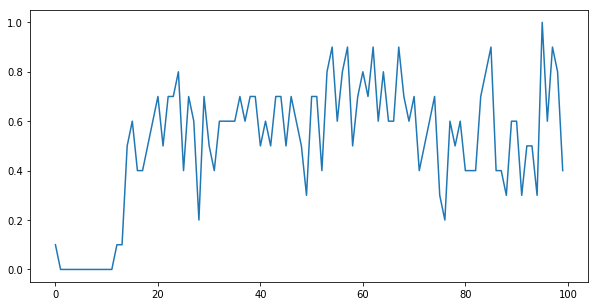

In [12]:
plt.figure(figsize=(10,5))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp)
plt.show()

In [13]:
!python --version

Python 3.6.6 :: Anaconda custom (64-bit)


In [14]:
!pip freeze

absl-py==0.2.2
alabaster==0.7.10
algopy==0.5.7
altair==2.1.0
anaconda-client==1.6.5
anaconda-navigator==1.6.9
anaconda-project==0.8.0
annoy==1.12.0
appdirs==1.4.3
arrow==0.12.1
asn1crypto==0.22.0
astor==0.7.1
astroid==1.5.3
astropy==2.0.2
atari-py==0.1.1
attrs==18.1.0
audioread==2.1.6
Babel==2.5.0
backports.shutil-get-terminal-size==1.0.0
Baker==1.3
basemap==1.1.0
bayesian-optimization==0.6.0
bayespy==0.5.17
bcolz==1.2.1
beautifulsoup4==4.6.0
biopython==1.72
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==1.5.0
blist==1.3.6
bokeh==0.13.0
Boruta==0.1.5
boto==2.48.0
boto3==1.7.54
botocore==1.10.54
Bottleneck==1.2.1
Box2D-kengz==2.3.3
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
branca==0.3.0
bz2file==0.98
cachetools==2.1.0
cairocffi==0.8.1
CairoSVG==2.1.3
Cartopy==0.16.0
catboost==0.9.1.1
category-encoders==1.2.8
certifi==2018.4.16
cffi==1.10.0
chainer==4.2.0
chardet==3.0.4
click==6.7
click-plugins==1.0.3
cligj==0.4.0
clo